In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!pip install shutup

In [5]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torchvision.datasets import MNIST
import matplotlib.pylab as plt
import numpy as np
from torch.optim import Adam, SGD
import random
import math
import random
from random import choice
torch.manual_seed(17)
import os
from statistics import mode
from scipy import stats
import pickle
import cv2
import sklearn
from sklearn.model_selection import train_test_split
import time
import pandas as pd
import matplotlib
import shutup; shutup.please()
from torchsummary import summary

In [61]:
# def show_data(data_sample):
#   plt.imshow(data_sample[0].reshape(32,32), cmap='gray')
#   diff = np.max(np.absolute(np.subtract(data_sample[0],data_sample[3])))
#   plt.title('y_true = '+ str(data_sample[1]) + ' y_pred = '+str(data_sample[2])+" Diff = "+str(diff))

def show_data_2(data_sample, pred_label):
  plt.figure()
  plt.imshow(data_sample.reshape(28,28), cmap='gray')
  plt.title('y_pred = '+str(pred_label))
  plt.show()


In [7]:
x_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECE657A/A4/x_train.csv').astype('float')/255.0
x_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECE657A/A4/x_test.csv').astype('float')/255.0
y_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECE657A/A4/y_train.csv')
y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ECE657A/A4/y_test.csv')

In [8]:
x_train_data = x_train.values
x_test_data = x_test.values
y_train_data = y_train.values
y_test_data = y_test.values

In [9]:
x_train_data, x_val_data, y_train_data, y_val_data = train_test_split(x_train_data,y_train_data, test_size = 0.2)

In [10]:
def build_dataloader(data=x_train_data,label = y_train_data, batch_size = 100):
    ip = []
    lab = []
    tmp_ip = []
    tmp_lab = []
    count = 0
    for t,l in zip(data,label):
        tmp_ip.append(cv2.resize(t,(32,32)).reshape(1,32,32))
        tmp_lab.append(int(l))
        count+=1
        if count%batch_size == 0:
            ip.append(torch.tensor(tmp_ip))
            lab.append(torch.tensor(np.array(tmp_lab)))
            tmp_ip = []
            tmp_lab = []
    return (ip,lab)

def preprocess_ip(x):
  return torch.tensor(cv2.resize(x,(32,32)).reshape(1,1,32,32))


In [11]:
loader= build_dataloader()
val_loader = build_dataloader(data = x_val_data, label = y_val_data )
test_loader = build_dataloader(data = x_test_data, label = y_test_data)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)
  if sys.path[0] == '':


In [21]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.cnn1 = nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size=3, stride = 1, padding = 1)
    self.relu1 = nn.ReLU()
    self.maxpool1 = nn.MaxPool2d(kernel_size=2)
    self.cnn2 = nn.Conv2d(in_channels = 32, out_channels = 32, kernel_size = 3, stride = 1, padding = 1 )
    self.fc1 = nn.Linear(2048,5)
    self.softmax = nn.Softmax()

  def forward(self,x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.softmax(out)
    return out

  def train(self, train_loader,opt, loss_fn, BATCH_SIZE, eval = True):
    loss_tot = 0
    acc = 0
    cnt = 0
    for x,y in zip(train_loader[0], train_loader[1]):
      cnt+=1
      x = x.float()
      x = x.cuda()
      y = y.cuda()
      opt.zero_grad()
      z = self.forward(x)
      y = torch.nn.functional.one_hot(y, num_classes=5)
      loss = loss_fn(z.double(),y.double())
      loss_tot+= loss.item()
      loss.backward()
      opt.step()
      if cnt%1000==0:
        print("Loss is ",loss.item())
    loss_tr = loss_tot/(len(train_loader[1]))
    if eval:
      correct = 0
      for x,y in zip(train_loader[0],train_loader[1]):
        x = x.float()
        x = x.cuda()
        y = y.cuda()
        z = self.forward(x)
        _,yhat = torch.max(z.data,1)
        correct += (yhat== y).sum().item()
      acc = correct/(len(train_loader[1])*BATCH_SIZE)
    return loss_tr,acc
    
  def eval(self,loader,BATCH_SIZE,loss_fn=nn.CrossEntropyLoss()):
    correct = 0
    acc = 0
    loss_tot = 0
    for x,y in zip(loader[0],loader[1]):
      x = x.float()
      x = x.cuda()
      y = y.cuda()
      z = self.forward(x)
      loss = loss_fn(z.double(),y.long())
      loss_tot += loss.item()
      _ , yhat = torch.max(z.data,1)
      correct += (yhat == y).sum().item()
    acc = correct/(len(loader[1]))
    loss_val = loss_tot/(len(loader[1])*BATCH_SIZE)
    return loss_val, acc  


#[CM1] Classification with CNN
## Default Network
### Model 1 - summary

In [22]:
model = CNN()
model = model.cuda()
summary(model, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             320
              ReLU-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           9,248
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                    [-1, 5]          10,245
           Softmax-8                    [-1, 5]               0
Total params: 19,813
Trainable params: 19,813
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.70
Params size (MB): 0.08
Estimated Total Size (MB): 0.78
----------------------------------------------------------------


**Network Architecture:**  
We add convolutional layers and flatten the final result to feed into the densely connected layers.Finally we add the densely connected layers. We configure the network as per the given network specification.

**Activation Functions**:
1. **Relu**  
effectively means "If X>0 return X, else return 0" -- so what it does is it only passes values0 or greater to the next layer in the network. ReLU stands for Rectifi ed Linear Unit. The mainadvantage of using the ReLU function over other activation functions is that it does notactivate all the neurons at the same time. This means that the neurons will only be deactivatedif the output of the linear transformation is less than 0. For the negative input values, the resultis zero, that means the neuron does not get activated. Since only a certain number of neuronsare activated, the ReLU function is far more computationally efficient when compared to the sigmoid and tanh function. Due to this reason, during the backpropogation process, the weights and biases for some neurons are not updated.
2. **Softmax**  
Since our problem is a classification problem, we employ softmax as the activation function of last layer.


**Optimizer:** We have used "adam" optimizer while compiling the model because Adam combines thebest properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm thatcan handle sparse gradients on noisy problems. Adam is relatively easy to confi gure where thedefault confi guration parameters do well on most problems.  

**Loss Function:** Since our problem is a classification problem, we use CrossEntropyLoss.


In [23]:
opt = Adam(model.parameters(), lr = 0.001)
crit = nn.CrossEntropyLoss()
model = model.cuda()

tr_loss = []
tr_acc = []
val_acc = []
val_loss = []
training_time_tot = 0
for epoch in range(50):
  start_time = time.time()
  l, a = model.train(train_loader=loader,opt = opt, loss_fn = crit, BATCH_SIZE=100)
  end_time = time.time()
  training_time_tot += end_time - start_time
  print("Epoch ",epoch+1,"--> ",a)
  tr_loss.append(l)
  tr_acc.append(a)
  l,a = model.eval(loader=val_loader,BATCH_SIZE=100)
  val_acc.append(a)
  val_loss.append(l)

Epoch  1 -->  0.793
Epoch  2 -->  0.8001458333333333
Epoch  3 -->  0.8012291666666667
Epoch  4 -->  0.8219791666666667
Epoch  5 -->  0.828625
Epoch  6 -->  0.8310416666666667
Epoch  7 -->  0.8275
Epoch  8 -->  0.8319791666666667
Epoch  9 -->  0.8355
Epoch  10 -->  0.8405416666666666
Epoch  11 -->  0.8321875
Epoch  12 -->  0.8409583333333334
Epoch  13 -->  0.8414583333333333
Epoch  14 -->  0.8387916666666667
Epoch  15 -->  0.8468958333333333
Epoch  16 -->  0.8455208333333334
Epoch  17 -->  0.8419375
Epoch  18 -->  0.8466041666666667
Epoch  19 -->  0.8512916666666667
Epoch  20 -->  0.84575
Epoch  21 -->  0.8535416666666666
Epoch  22 -->  0.852
Epoch  23 -->  0.8468958333333333
Epoch  24 -->  0.8460208333333333
Epoch  25 -->  0.8494375
Epoch  26 -->  0.8529791666666666
Epoch  27 -->  0.8526458333333333
Epoch  28 -->  0.8529791666666666
Epoch  29 -->  0.8561875
Epoch  30 -->  0.8540208333333333
Epoch  31 -->  0.8549583333333334
Epoch  32 -->  0.8591041666666667
Epoch  33 -->  0.85116666666

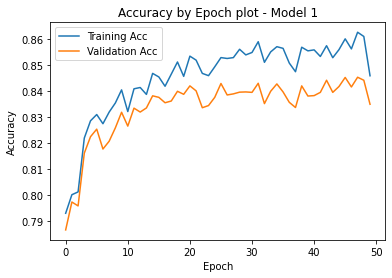

In [32]:
plt.plot(tr_acc, label = 'Training Acc')
plt.plot(np.array(val_acc)/100.0, label = 'Validation Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy by Epoch plot - Model 1")
plt.legend()
plt.show()

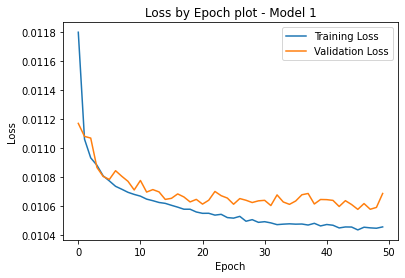

In [38]:
plt.plot(np.array(tr_loss)/100, label = 'Training Loss')
plt.plot(np.array(val_loss), label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss by Epoch plot - Model 1")
plt.legend()

In [ ]:
test_loss,test_acc = model.eval(loader=test_loader,BATCH_SIZE=100)
print("Test loss for Model 1 is ", test_loss)
print("Test accuracy for Model 1 is ", test_acc)

Test loss for Model 1 is  0.010652118769183854
Test accuracy for Model 1 is  83.85


**Model 1 Performance:**    
Based on training and validation accuracy, we can see that there is no overfitting that is affecting the model as validation accuracy closely follows training accuracy. We conclude training of the model after 50 epochs. Test accuracy for this model after training for 50 epochs is 83.85%. The factors upon which the accuracy depends includes a lot of factors outside of network architecture. Some of those factors are learning rate, number of epochs, network initialization etc.

# [CM2] Our Own Network

In [39]:
class Simple_CNN(nn.Module):
  def __init__(self, out_1=16, out_2=32, out_3 = 64):
      super(Simple_CNN, self).__init__()
      self.cnn1 = nn.Conv2d(in_channels=1, out_channels=out_1, kernel_size=3, padding=1)
      self.relu1 = nn.ReLU()
      self.maxpool1 = nn.MaxPool2d(kernel_size=2,stride=2)
      self.cnn2 = nn.Conv2d(in_channels=out_1, out_channels=out_2, kernel_size=3, stride=1, padding=1)
      self.relu2 = nn.ReLU()
      self.maxpool2 = nn.MaxPool2d(kernel_size=2,stride=2)
      self.cnn3 = nn.Conv2d(in_channels=out_2, out_channels=out_3, kernel_size=3, stride=1, padding=1)
      self.maxpool3 = nn.MaxPool2d(kernel_size=2,stride=2)
      self.relu3 = nn.ReLU()
      self.fc1 = nn.Linear(out_2 * 8 * 8, 500)
      self.fc2 = nn.Linear(500, 50)
      self.fc3 = nn.Linear(50,5)
      self.softmax = nn.Softmax()
      self.sig = nn.Sigmoid()

  def forward(self,x):
      out = self.cnn1(x)
      out = self.relu1(out)
      out = self.maxpool1(out)
      out = self.cnn2(out)
      out = self.relu2(out)
      out = self.maxpool2(out)
      out = out.view(out.size(0), -1)
      out = self.fc1(out)
      out = self.relu1(out)
      out = self.fc2(out)
      out = self.relu1(out)
      out = self.fc3(out)
      out = self.softmax(out)
      return out

  def forward2(self,x):
    out = self.cnn1(x)
    out = self.relu1(out)
    out = self.maxpool1(out)
    out = self.cnn2(out)
    out = self.relu2(out)
    out = self.maxpool2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.relu1(out)
    out = self.fc2(out)
    out = self.relu1(out)
    out_enc = out.clone().detach()
    return out_enc



  def train(self, train_loader,opt, loss_fn, BATCH_SIZE, eval = True):
    loss_tot = 0
    acc = 0
    cnt = 0
    for x,y in zip(train_loader[0], train_loader[1]):
        cnt+=1
        x = x.float()
        x = x.cuda()
        y = y.cuda()
        opt.zero_grad()
        z = self.forward(x)
        y = torch.nn.functional.one_hot(y, num_classes=5)
        loss = loss_fn(z.double(),y.double())
        loss_tot+= loss.item()
        loss.backward()
        opt.step()
    loss_tr = loss_tot/(len(train_loader[1]))
    if eval:
      correct = 0
      for x,y in zip(train_loader[0],train_loader[1]):
        x = x.float()
        x = x.cuda()
        y = y.cuda()
        z = self.forward(x)
        _,yhat = torch.max(z.data,1)
        correct += (yhat== y).sum().item()
      acc = correct/(len(train_loader[1])*BATCH_SIZE)
    return loss_tr,acc
      
  def eval(self,loader,BATCH_SIZE,loss_fn=nn.CrossEntropyLoss()):
    correct = 0
    acc = 0
    loss_tot = 0
    for x,y in zip(loader[0],loader[1]):
      x = x.float()
      x = x.cuda()
      y = y.cuda()
      z = self.forward(x)
      loss = loss_fn(z.double(),y.long())
      loss_tot += loss.item()
      _ , yhat = torch.max(z.data,1)
      correct += (yhat == y).sum().item()
    acc = correct/(len(loader[1])*BATCH_SIZE)
    loss_val = loss_tot/(len(loader[1])*BATCH_SIZE)
    return loss_val, acc  

  def pred(self,x):
    x = x.float()
    x = x.cuda()
    z = self.forward(x)
    _,yhat = torch.max(z.data,1)
    return yhat.item()


In [40]:
model2 = Simple_CNN()
model2 = model2.cuda()
summary(model2, (1,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             160
              ReLU-2           [-1, 16, 32, 32]               0
         MaxPool2d-3           [-1, 16, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
              ReLU-5           [-1, 32, 16, 16]               0
         MaxPool2d-6             [-1, 32, 8, 8]               0
            Linear-7                  [-1, 500]       1,024,500
              ReLU-8                  [-1, 500]               0
            Linear-9                   [-1, 50]          25,050
             ReLU-10                   [-1, 50]               0
           Linear-11                    [-1, 5]             255
          Softmax-12                    [-1, 5]               0
Total params: 1,054,605
Trainable params: 1,054,605
Non-trainable params: 0
---------------------------

**Architecture**:  
The network architecture summary is shown above. We have 2 convolution layers, each with stride 1 and padding 1. First layer has 16 filters while the second one has 32 filters. The choice of pooling is max pool for all conv layers. The choice of activation function is ReLU. We flatten the output of convolution and employ FCC with 500 followed by a layer containing 50 neurons followed by the output layer. Here too, the choice of activation function is ReLU followed by Softmax at the output layer since our problem is of classification nature.  

**Optimizer:** We have used "adam" optimizer while compiling the model because Adam combines thebest properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm thatcan handle sparse gradients on noisy problems. Adam is relatively easy to confi gure where thedefault confi guration parameters do well on most problems.  

**Loss Function:** We used 'CrossEntropyLoss' since we one hot encoded the output.

In [41]:
opt = Adam(model2.parameters(), lr = 0.001)
crit = nn.CrossEntropyLoss()
model2 = model2.cuda()
tr_loss2 = []
tr_acc2 = []
val_acc2 = []
val_loss2 = []
training_time_tot = 0
for epoch in range(75):
  start_time = time.time()
  l, a = model2.train(train_loader=loader,opt = opt, loss_fn = crit, BATCH_SIZE=100)
  end_time = time.time()
  training_time_tot += end_time - start_time
  print("Epoch ",epoch+1,"--> ",a)
  tr_loss2.append(l)
  tr_acc2.append(a)
  l,a = model2.eval(loader=val_loader,BATCH_SIZE=100)
  val_acc2.append(a)
  val_loss2.append(l)

Epoch  1 -->  0.7931041666666667
Epoch  2 -->  0.8113541666666667
Epoch  3 -->  0.8221875
Epoch  4 -->  0.8348958333333333
Epoch  5 -->  0.8303958333333333
Epoch  6 -->  0.8438541666666667
Epoch  7 -->  0.8510208333333333
Epoch  8 -->  0.8503541666666666
Epoch  9 -->  0.8568958333333333
Epoch  10 -->  0.8565625
Epoch  11 -->  0.86025
Epoch  12 -->  0.8541458333333334
Epoch  13 -->  0.8589583333333334
Epoch  14 -->  0.86375
Epoch  15 -->  0.8653541666666666
Epoch  16 -->  0.8458333333333333
Epoch  17 -->  0.8689166666666667
Epoch  18 -->  0.8700625
Epoch  19 -->  0.8732708333333333
Epoch  20 -->  0.8670416666666667
Epoch  21 -->  0.87075
Epoch  22 -->  0.8787708333333333
Epoch  23 -->  0.8764791666666667
Epoch  24 -->  0.875875
Epoch  25 -->  0.8773958333333334
Epoch  26 -->  0.8699791666666666
Epoch  27 -->  0.8807291666666667
Epoch  28 -->  0.8785416666666667
Epoch  29 -->  0.8787291666666667
Epoch  30 -->  0.8834375
Epoch  31 -->  0.87875
Epoch  32 -->  0.88175
Epoch  33 -->  0.87718

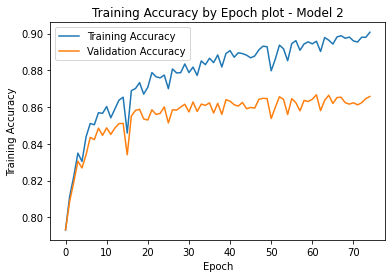

In [42]:
plt.plot(tr_acc2, label = 'Training Accuracy')
plt.plot(val_acc2, label = 'Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy by Epoch plot - Model 2")
plt.legend()

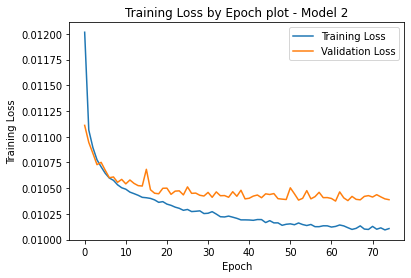

In [45]:
plt.plot(np.array(tr_loss2)/100, label = 'Training Loss')
plt.plot(val_loss2, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss by Epoch plot - Model 2")
plt.legend()

In [44]:
test_loss,test_acc = model2.eval(loader=test_loader,BATCH_SIZE=100)
print("Test loss for Model 2 is ", test_loss)
print("Test accuracy for Model 2 is ", test_acc)

Test loss for Model 2 is  0.010438133199435765
Test accuracy for Model 2 is  0.86


**Model 2 - Performance Analysis**  
Looking at the training and validation set accuracy, we can see that there is no overfitting happening. The test accuracy for this model is 85% which is slightly better than model 1. One constraint that we considered in network design is the complexity of the model since going for model of higher complexity would result in training time increasing a lot which becomes an overhead in performing iterations. Also, complex models are more prone to overfit the data.

# [CM3]

## Model 1 - Run time performance

In [ ]:
pred_start_time = time.time()
test_loss, test_acc = model.eval(loader = test_loader, BATCH_SIZE = 1)
pred_end_time = time.time()
print("Prediction time for Model 1 is ",(pred_end_time-pred_start_time)/len(test_loader)," seconds per sample")
print("Training time for Model 1 is ",training_time_tot," seconds")

Prediction time for Model 1 is  0.07086455821990967  seconds per sample
Training time for Model 1 is  102.02685689926147  seconds


## Model 2 - Run time performance

In [ ]:
pred_start_time = time.time()
test_loss, test_acc = model2.eval(loader = test_loader, BATCH_SIZE = 1)
pred_end_time = time.time()
print("Prediction time for Model 2 is ",(pred_end_time-pred_start_time)/len(test_loader)," seconds per sample")
print("Training time for Model 2 is ",training_time_tot," seconds")

Prediction time for Model 2 is  0.04983115196228027  seconds per sample
Training time for Model 2 is  130.02915930747986  seconds


**Execution Time:** Since the models are relatively simpler, the run time performance was decent. Model 1 trained in 102 seconds while model 2 trained in 130 seconds. We can note that the training time increases with model complexity. 

Runtime Performance depends on following factors:  
**Size of the model and design**
- In terms of no of parameters, no of layers (depth). Convolution,despite requiring few parameters, is computationally intensive. So the number of convolution layers will have an impact on the runtime performance of the algorithm (both training andevaluation).  

**Batch size**
- This factor impacts training time and model convergence. We need to strike a balance in this hyper parameter as having high batch size will cause GPU memory overflow.

**Hardware:** Usage of GPU significantly boosts the run time permormance mainly due to ability to run things in parallel. In our execution, we are using google colab with GPU run time for hardware acceleration.

|Model 1||Model 1||Model 2||Model 2|
|-------||-------||-------||-------|
|Training per epoch|| Testing per epoch||Training per epoch|| Testing per epoch|
|102s||0.07s||130s||0.04s||-------|

|Epoch||Training Accuracy||Validation accuracy||Training Accuracy||Validation accuracy|
|-------||-------||-------||-------||-------|
|10||0.79||0.82||0.79||0.845|
|20||0.84||0.835||0.85||0.855|
|30||0.85||0.838||0.86||0.857|
|40||0.85||0.84||0.88||0.86|
|50||0.86||0.83||0.89||0.85|

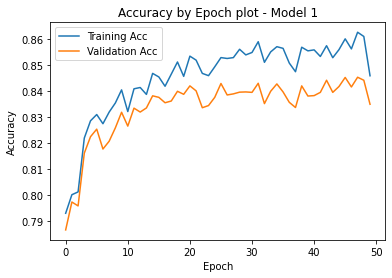

In [ ]:
plt.plot(tr_acc, label = 'Training Acc')
plt.plot(np.array(val_acc)/100.0, label = 'Validation Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy by Epoch plot - Model 1")
plt.legend()
plt.show()

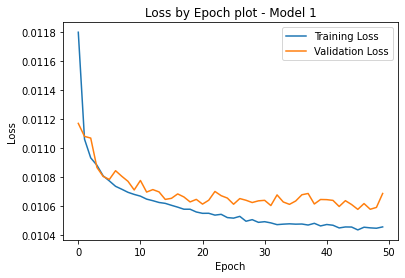

In [ ]:
plt.plot(np.array(tr_loss)/100, label = 'Training Loss')
plt.plot(np.array(val_loss), label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss by Epoch plot - Model 1")
plt.legend()

In [ ]:
test_loss,test_acc = model.eval(loader=test_loader,BATCH_SIZE=100)
print("Test loss for Model 1 is ", test_loss)
print("Test accuracy for Model 1 is ", test_acc)

Test loss for Model 1 is  0.010652118769183854
Test accuracy for Model 1 is  83.85


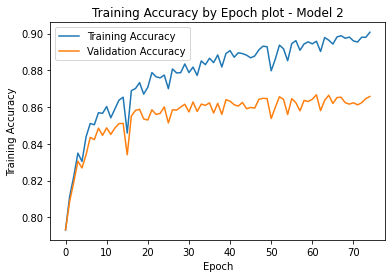

In [ ]:
plt.plot(tr_acc2, label = 'Training Accuracy')
plt.plot(val_acc2, label = 'Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy by Epoch plot - Model 2")
plt.legend()

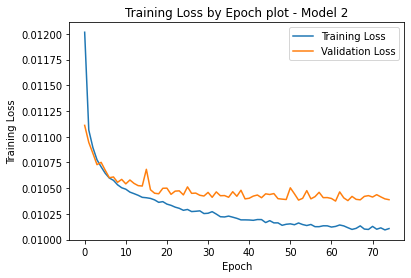

In [ ]:
plt.plot(np.array(tr_loss2)/100, label = 'Training Loss')
plt.plot(val_loss2, label = 'Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss by Epoch plot - Model 2")
plt.legend()

In [ ]:
test_loss,test_acc = model2.eval(loader=test_loader,BATCH_SIZE=100)
print("Test loss for Model 2 is ", test_loss)
print("Test accuracy for Model 2 is ", test_acc)

Test loss for Model 2 is  0.010438133199435765
Test accuracy for Model 2 is  0.86


# [CM4]

From Model 2, we take the encoding of second FCC layer and use that for this exercise. Since there are 50 neurons in this layer, the dimension of data at this layer is 50. We reduce that to 2 dimensions using PCA for the purpose of data visualization.

In [ ]:
loader2= build_dataloader(data = x_train_data, label = y_train_data, batch_size=1)
input_embedding = []
input_label = []
for x,y in zip(loader2[0],loader2[1]):
  x = x.float()
  x = x.cuda()
  y = y.numpy()
  z = model2.forward2(x) 
  input_embedding.append(z.cpu().numpy()[0])
  input_label.append(y)

In [ ]:
ip_emb = []
ip_label = []
for ip,y in zip(input_embedding, input_label):
  if not(np.isnan(ip).any()):
    ip_emb.append(ip)
    ip_label.append(y)

In [ ]:
ip_label = np.array(ip_label)
ip_emb = np.array(ip_emb)

#PCA

Text(0, 0.5, 'PCA dim 2')

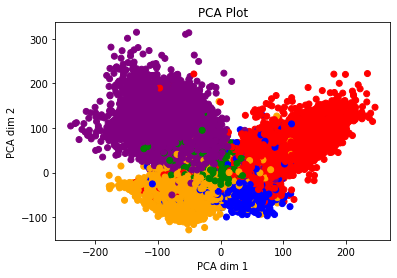

In [ ]:
embedded_ip = np.array(ip_emb)
embedded_label = np.array(ip_label)
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(embedded_ip)
x_2d = pca.transform(embedded_ip)
colors = ['red','green','blue','purple', 'orange']
plt.scatter(x_2d[:,0], x_2d[:,1],c=ip_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("PCA Plot")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")

From the plot, it is evident that at this stage, the data is fairly clustered based on their class. One can note that the clusters being formed are of sperical in nature. This actually shows that this data can effectively be clustered by algorithms like k-means clustering.

#DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN
clustering_labels = DBSCAN(eps=4, min_samples=15).fit_predict(embedded_ip)

Text(0, 0.5, 'PCA dim 2')

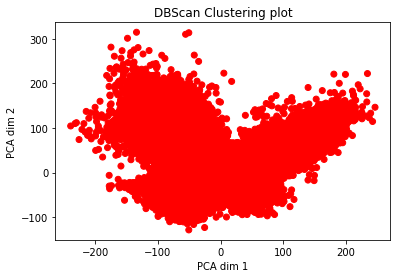

In [ ]:
plt.scatter(x_2d[:,0], x_2d[:,1],c=clustering_labels, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("DBScan Clustering plot")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")

DBScan is a clustering algorithm that is very good at forming non-sperical shaped clusters (clusters of unusual shape). This algorithm depends mainly on density. Since our original dataset forms sperical cluster at the point where we take the encoded data, and since the points appear to be of similar density, we are getting poor performance.

#KMeans

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(ip_emb)

Text(0, 0.5, 'PCA dim 2')

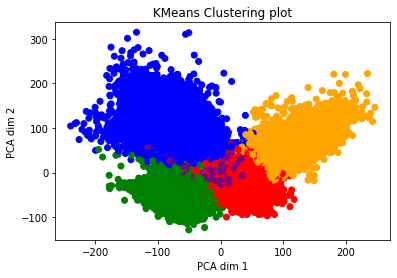

In [ ]:
plt.scatter(x_2d[:,0], x_2d[:,1],c=kmeans.labels_, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("KMeans Clustering plot")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")

Since the original data at the point where we have taken forms sperical clusters, k-means clustering has decently clustered the points into its classes.

#TSNE 

In [ ]:
from sklearn.manifold import TSNE
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(ip_emb)

Text(0, 0.5, 'PCA dim 2')

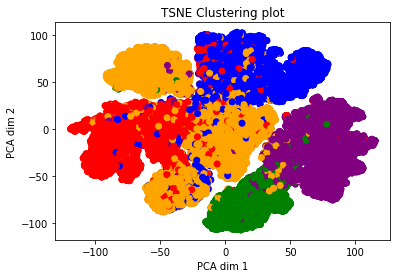

In [ ]:
plt.scatter(X_embedded[:,0], X_embedded[:,1],c=ip_label, cmap=matplotlib.colors.ListedColormap(colors))
plt.title("TSNE Clustering plot")
plt.xlabel("PCA dim 1")
plt.ylabel("PCA dim 2")

TSNE is mainly used to effectively visualize data of higher dimension. We can see that clusters are well separated and the degree of separation is better than that of PCA.

Label 0 images


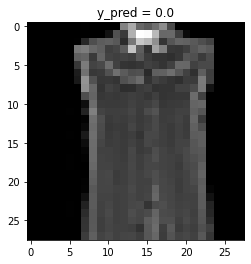

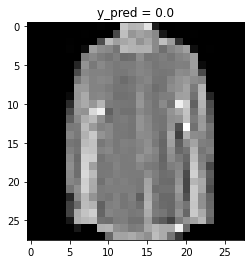

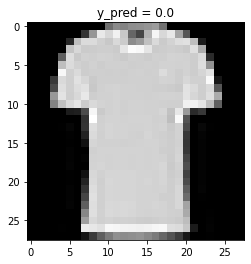

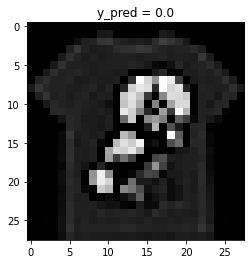

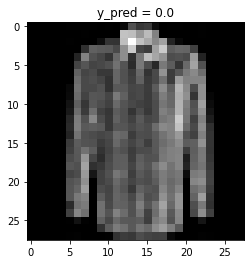

In [69]:
print("Label 0 images")
for i in range(5):
  show_data_2(pred_0.values[i,0:-1], pred_0.values[i,-1])

Label 1 images


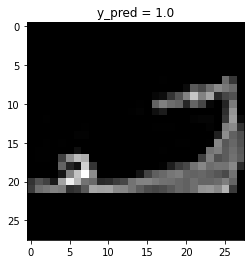

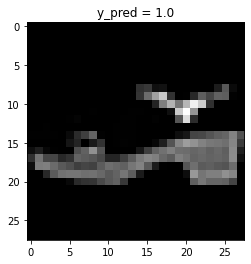

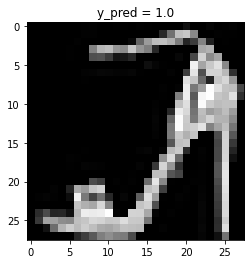

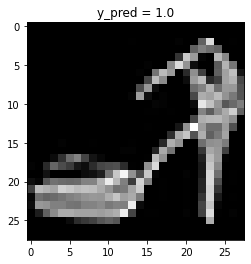

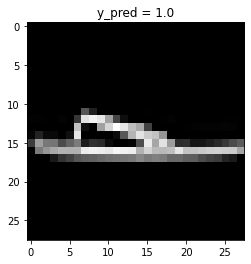

In [70]:
print("Label 1 images")
for i in range(5):
  show_data_2(pred_1.values[i,0:-1], pred_1.values[i,-1])

Label 2 images


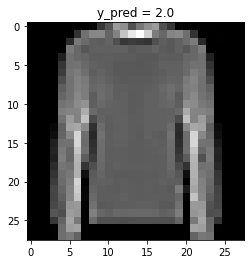

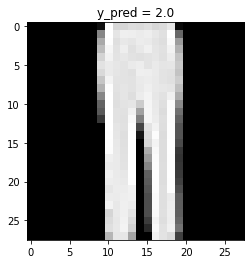

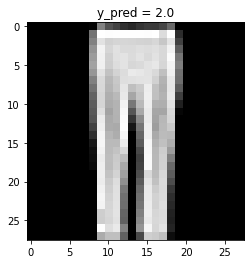

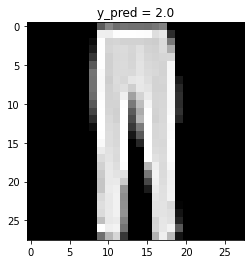

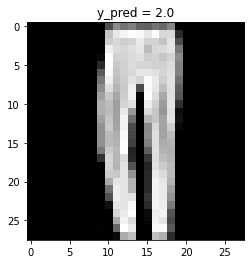

In [71]:
print("Label 2 images")
for i in range(5):
  show_data_2(pred_2.values[i,0:-1], pred_2.values[i,-1])

Label 3 images


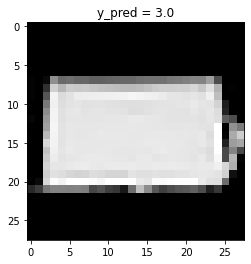

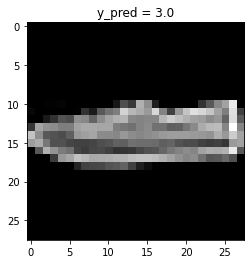

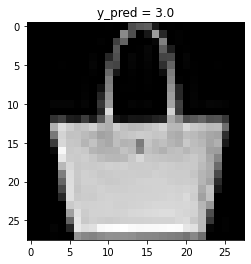

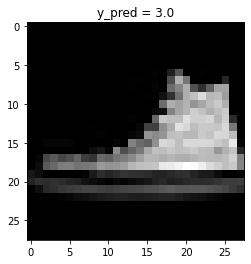

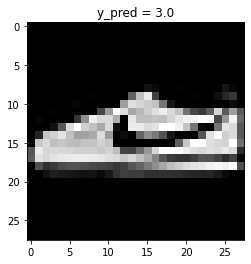

In [72]:
print("Label 3 images")
for i in range(5):
  show_data_2(pred_3.values[i,0:-1], pred_3.values[i,-1])

Label 4 images


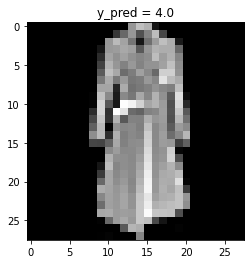

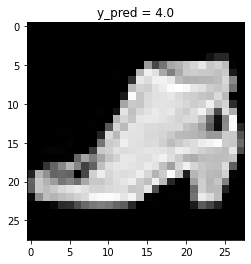

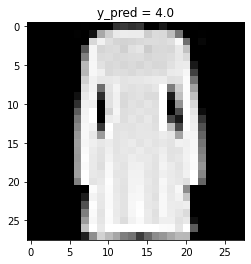

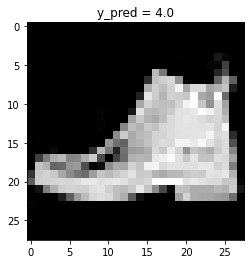

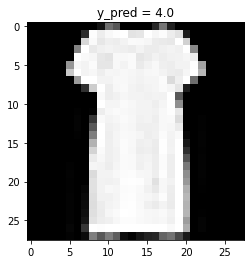

In [75]:
print("Label 4 images")
for i in range(5):
  show_data_2(pred_4.values[i,0:-1], pred_4.values[i,-1])

Group 0 - Tops, T-Shirts, Pullovers and Coats
Group 1 - Sandles and Heels
Group 2 - Trousers, One Shirt that is incorrectly classified
Group 3 - Clutch,Bags, Shoes, Sneakers
Group 4 - Boots and Dresses

Clustering does not utlize labels however it groups similar types of objects together to a certain extent. We can see similar behaviour here.


REFERENCES:  
https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html  
https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html  
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html  
https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html  
https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html  
